In [2]:
# kiarash Geraili, 83040048
# instructor: hadi veisi
# Email: kiarash.geraili@gmail.com

In [3]:
import numpy as np
import os
from matplotlib import pyplot
from matplotlib import image
from sklearn.model_selection import train_test_split
    
image_size = 256
splited_image_size = 8
input_layer_size = splited_image_size**2

training_files = os.listdir("TrainSet")
training_size = len(training_files)
test_files = os.listdir("TestSet")
test_size = len(test_files)

In [4]:
def split_image(image, size):
    h, w = image.shape
    return (image.reshape(h//size, size, -1, size)
               .swapaxes(1,2)
               .reshape(-1, size, size))
    
train_data = np.empty((training_size*(image_size//splited_image_size)**2,splited_image_size, splited_image_size))
for i in range(training_size):
    img = image.imread(os.path.join("TrainSet", training_files[i]))/ 255
    img = split_image(img, splited_image_size)
    idx = i*(image_size//splited_image_size)**2
    train_data[idx:(idx + img.shape[0])] = img
train_data = train_data.reshape(train_data.shape[0], -1)
train_data.shape

(93184, 64)

In [5]:
test_data = np.empty((test_size*(image_size//splited_image_size)**2,splited_image_size, splited_image_size))
for i in range(test_size):
    img = image.imread(os.path.join("TestSet", test_files[i]))/ 255
    img = split_image(img, splited_image_size)
    idx = i*(image_size//splited_image_size)**2
    test_data[idx:(idx + img.shape[0])] = img
test_data = test_data.reshape(test_data.shape[0], -1)

In [6]:
def sigmoid(x):
    return 1/(1 + np.exp(-1*x))

def relu(x):
    return np.maximum(np.zeros_like(x),x)


def sigmoid_grad(x):
    return sigmoid(x) * (1 - sigmoid(x))

def relu_grad(x):
    return np.array(x > 0).astype(int)  

In [7]:
class MLP:
    def __init__(self, X, T, learning_rate, layers_list, momentum = 0, activation = 'sigmoid'):
        self.X = X
        self.T = T
        self.momentum = momentum
        self.learning_rate = learning_rate
        input_size = X.shape[1]
        output_size = T.shape[1]
        layers_list.append(output_size)
        layers_list.insert(0, input_size)
        self.W = [np.random.randn(layers_list[i+1], layers_list[i])/100 for i in range(len(layers_list)-1)]
        self.b = [np.atleast_2d(np.random.randn(layers_list[i])).T/100 for i in range(1, len(layers_list))]
        if activation == 'sigmoid':
            self.activation = sigmoid
            self.activation_grad = sigmoid_grad
        elif activation == 'relu':
            self.activation = relu
            self.activation_grad = relu_grad
    
    def forward_propagation(self, X):
        Y=[np.atleast_2d(X).T]
        Y_in = []
        for i in range(len(self.W)):
            y = Y[-1]
            Z_in = np.matmul(self.W[i],y) + self.b[i]
            Z = self.activation(Z_in)
            Y.append(Z)
            Y_in.append(Z_in)
        return (Y, Y_in)

        
    def back_propagation(self, Y, Y_in, T):
        dW = []
        db = []
        Y_last = Y.pop()
        Y_in_last = Y_in.pop()
        sigma_in = np.atleast_2d(T).T - Y_last
        sigma = sigma_in * self.activation_grad(Y_in_last)
        dW.insert(0, self.learning_rate * sigma * Y[-1].T)
        db.insert(0, self.learning_rate * sigma)
        for i in range(len(self.W)-1,0,-1):
            Y_i = Y.pop()
            Y_in_i = Y_in.pop()
            sigma_in = np.matmul(self.W[i].T, sigma)
            sigma = sigma_in * self.activation_grad(Y_in_i)
            dW.insert(0, self.learning_rate * sigma * Y[-1].T)
            db.insert(0, self.learning_rate * sigma)
        return dW, db
        
    def train(self, X_test, T_test, epoch=1, batch_size = 1, end_condition = 0.001):
        test_PSNR = []
        test_MSE = []
        train_PSNR = []
        train_MSE = []
        for _ in range(epoch): 
            for i in range(self.X.shape[0]//batch_size):
                total_dW = [np.zeros_like(W_i) for W_i in self.W]
                total_db = [np.zeros_like(b_i) for b_i in self.b]
                dW_prev = [np.zeros_like(W_i) for W_i in self.W]
                for j in range(batch_size):
                    Y, Y_in = self.forward_propagation(self.X[i * batch_size + j])
                    dW, db = self.back_propagation(Y, Y_in, self.T[i * batch_size + j])
                    for k in range(len(dW)):
                        total_dW[k] += dW[k]
                        total_db[k] += db[k]
                for j in range(len(dW)):
                    self.W[j] += (total_dW[j]/batch_size + self.momentum * dW_prev[j])
                    self.b[j] += total_db[j]/batch_size
                    dW_prev[j] = total_dW[j]/batch_size + self.momentum * dW_prev[j]

            mean_test_PSNR = np.mean(self.PSNR(X_test, T_test))
            mean_test_MSE = np.mean(self.MSE(X_test, T_test))
            mean_train_PSNR = np.mean(self.PSNR(self.X, self.T))
            mean_train_MSE = np.mean(self.MSE(self.X, self.T))

            test_PSNR.append(mean_test_PSNR)
            test_MSE.append(mean_test_MSE)
            train_PSNR.append(mean_train_PSNR)
            train_MSE.append(mean_train_MSE)

            if mean_train_MSE <= end_condition:
                break

        return test_PSNR, test_MSE, train_PSNR, train_MSE


    def PSNR(self, X_test, T_test):
          return 10 * np.log10(1/self.MSE(X_test, T_test))

    def MSE(self, X_test, T_test):
        T = np.apply_along_axis(lambda x: self.forward_propagation(x)[0][-1], 1, X_test)
        T_test = np.atleast_3d(T_test)
        return np.sum((T-T_test)**2, axis = 1)/T.shape[1]


In [ ]:
models = []
errors = []
layers = [4, 16, 32]
for n in layers:
    model = MLP(train_data, train_data, 0.1, layers_list=[n], momentum=0)
    _, _, _, train_MSE = model.train(test_data,test_data, 5)
    models.append(model)
    errors.append(train_MSE)
  


PSNR for house.jpg: 27.64
PSNR for crowd.jpg: 23.04
PSNR for camera.jpg: 31.55
PSNR for pepper.jpg: 28.15
PSNR for lena.jpg: 31.8



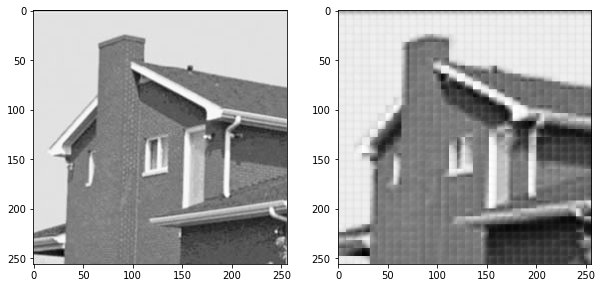

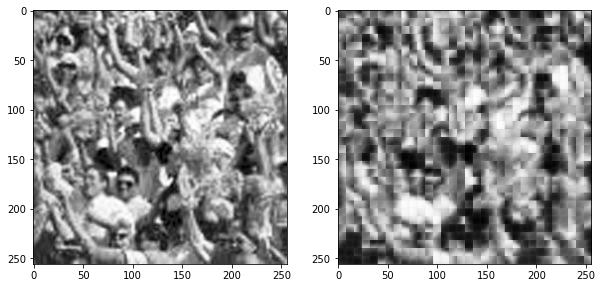

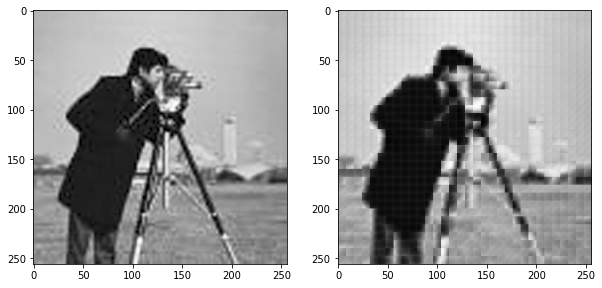

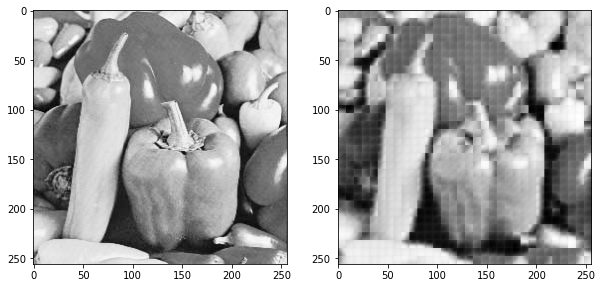

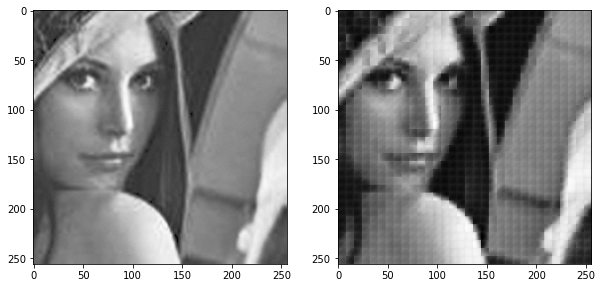

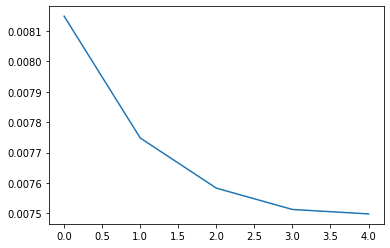

PSNR for house.jpg: 34.57
PSNR for crowd.jpg: 31.39
PSNR for camera.jpg: 36.93
PSNR for pepper.jpg: 33.11
PSNR for lena.jpg: 36.03



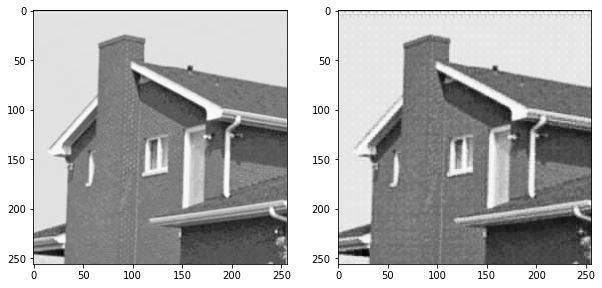

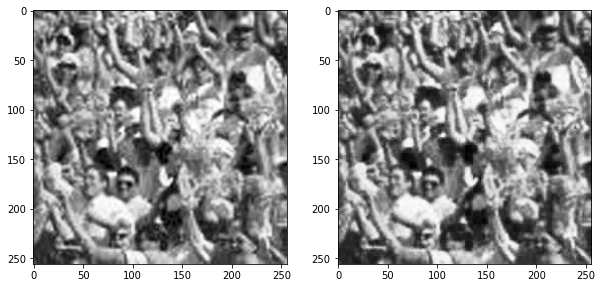

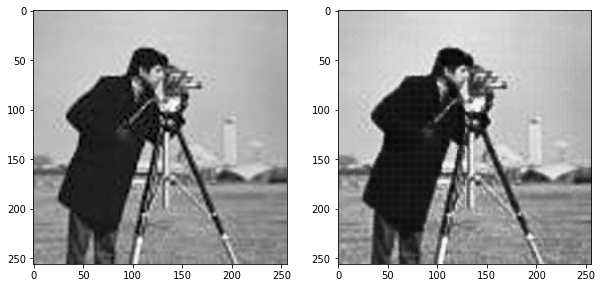

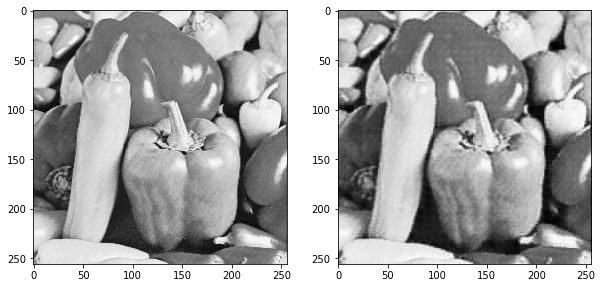

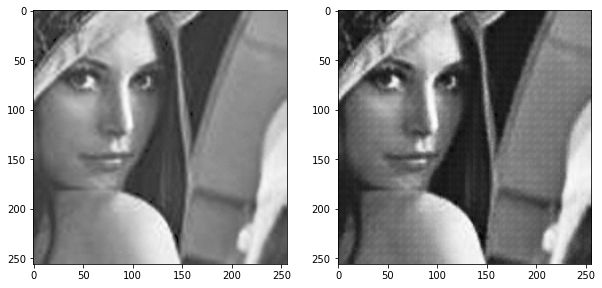

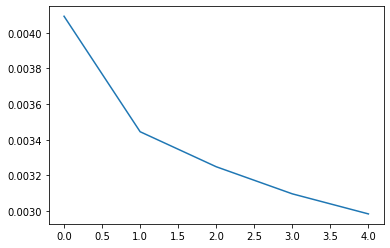

PSNR for house.jpg: 38.26
PSNR for crowd.jpg: 34.61
PSNR for camera.jpg: 39.39
PSNR for pepper.jpg: 36.89
PSNR for lena.jpg: 39.11



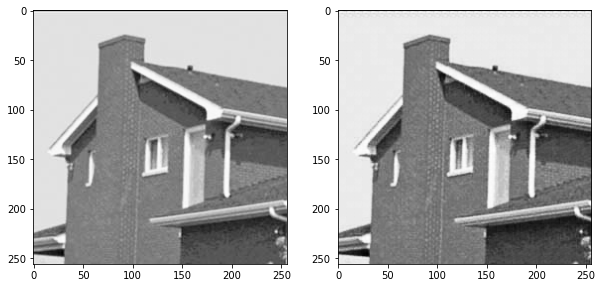

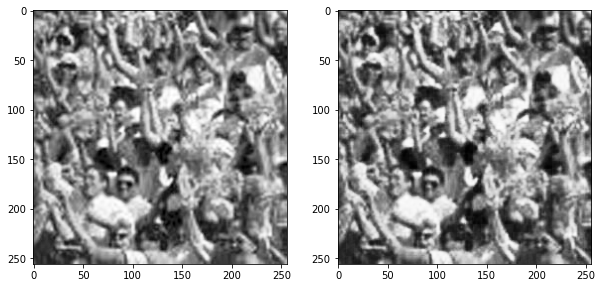

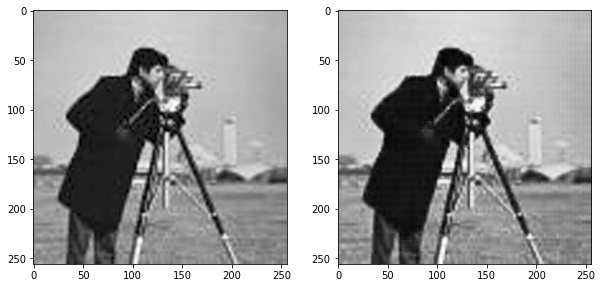

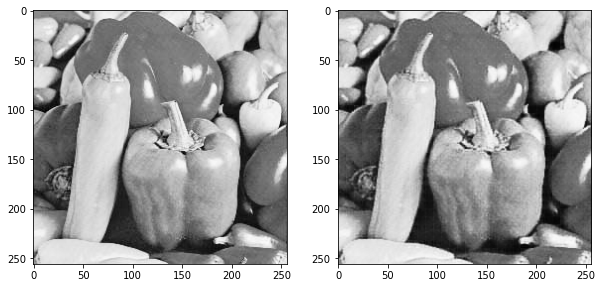

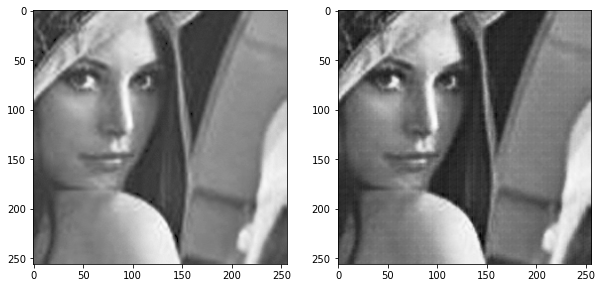

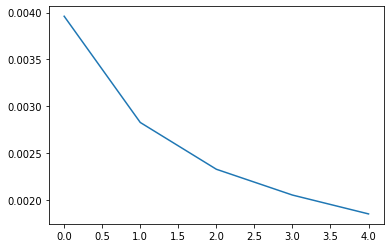

In [ ]:
for m_idx in range(len(models)):
    model = models[m_idx]
    train_MSE = errors[m_idx]
    model_PSNR = model.PSNR(test_data, test_data)
    mean_PSNR = np.mean(model_PSNR.reshape(-1, (image_size//splited_image_size)**2), axis = 1)
    for i in range(test_size):
        print('PSNR for ' + test_files[i] + ': ' + str(round(mean_PSNR[i], ndigits = 2)))
    print()
    X_full = np.empty((image_size,image_size))
    Y_full = np.empty((image_size,image_size))

    for k in range(test_size):
        for i in range(image_size//splited_image_size):
            for j in range(image_size//splited_image_size):
                x = test_data[i * image_size//splited_image_size + j + k*(image_size//splited_image_size)**2]
                X_full[i * splited_image_size:(i + 1) * splited_image_size,j * splited_image_size:(j + 1) * splited_image_size] = np.copy(x.reshape(splited_image_size,splited_image_size))
                y = model.forward_propagation(x)[0][-1]
                y = y.reshape(splited_image_size,splited_image_size)
                Y_full[i * splited_image_size:(i + 1) * splited_image_size,j * splited_image_size:(j + 1) * splited_image_size] = np.copy(y)
        fig, axs = pyplot.subplots(1, 2)
        fig.set_size_inches(10,5)
        axs[0].imshow(np.ones_like(X_full) - X_full , cmap='Greys')
        axs[1].imshow(np.ones_like(Y_full) - Y_full, cmap='Greys')
        pyplot.show()
    pyplot.plot(range(len(train_MSE)), train_MSE, label = 'Model with '+str(layers[m_idx])+" hidden units")
    pyplot.show()

In [ ]:
model_with_momentum = MLP(train_data, train_data, 0.1, layers_list=[16], momentum=0.5)
test_PSNR_momentum, _, train_PSNR_momentum, train_MSE_momentum = model_with_momentum.train(test_data,test_data, 25)

standard_model = MLP(train_data, train_data, 0.1, layers_list=[16], momentum=0)
test_PSNR_standard, _, train_PSNR_standard, train_MSE_standard = standard_model.train(test_data,test_data, 25)

PSNR of test set without momentum: 36.0014
PSNR of test set with momentum: 36.4745


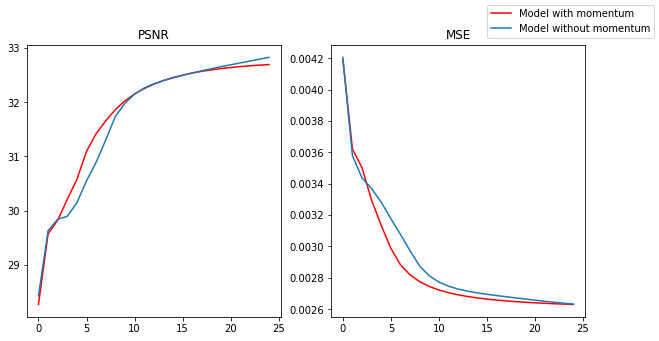

In [ ]:
print("PSNR of test set without momentum:", round(test_PSNR_standard[-1], ndigits = 4))
print("PSNR of test set with momentum:", round(test_PSNR_momentum[-1], ndigits = 4))
fig, axs = pyplot.subplots(1, 2)
fig.set_size_inches(10,5)
axs[0].plot(range(len(train_PSNR_momentum)), train_PSNR_momentum, 'r', label = 'Model with momentum')
axs[0].plot(range(len(train_PSNR_standard)), train_PSNR_standard, label = 'Model without momentum')
axs[0].set_title('PSNR')
axs[1].plot(range(len(train_MSE_momentum)), train_MSE_momentum, 'r')
axs[1].plot(range(len(train_MSE_standard)), train_MSE_standard)
axs[1].set_title('MSE')
fig.legend()
pyplot.show()

In [ ]:
from keras.datasets import mnist

(train_X, train_y), (test_X, test_y) = mnist.load_data()

_, train_X, _, train_y = train_test_split(train_X, train_y, test_size = 0.2, random_state = 42)
_, test_X, _, test_y = train_test_split(test_X, test_y, test_size = 0.2, random_state = 42)

print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))

11490434/11490434 [==============================] - 0s 0us/step
X_train: (12000, 28, 28)
Y_train: (12000,)
X_test:  (2000, 28, 28)
Y_test:  (2000,)


In [ ]:
train_X = train_X.reshape(train_X.shape[0], -1)/255
X_test = test_X.reshape(test_X.shape[0], -1)/255
y_test = np.atleast_2d(test_y).T

In [ ]:
X_train, X_validation, y_train, y_validation = train_test_split(train_X, train_y, test_size = 0.15, random_state = 42)

print('X_train: ' + str(X_train.shape))
print('Y_train: ' + str(y_train.shape))
print('X_validation:  '  + str(X_validation.shape))
print('Y_validation:  '  + str(y_validation.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))

X_train: (10200, 784)
Y_train: (10200,)
X_validation:  (1800, 784)
Y_validation:  (1800,)
X_test:  (2000, 28, 28)
Y_test:  (2000,)


In [ ]:
y_train = np.atleast_2d(y_train).T
y_validation = np.atleast_2d(y_validation).T
y_validation.shape

(1800, 1)

In [ ]:
model = MLP(X_train, X_train, 0.001, layers_list=[64], momentum=0)
_, _, train_PSNR, train_MSE = model.train(X_test, X_test, 5)

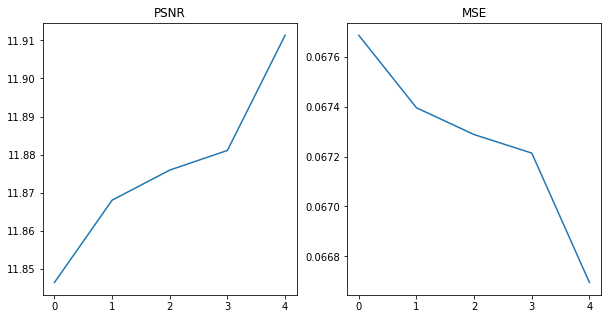

In [ ]:
fig, axs = pyplot.subplots(1, 2)
fig.set_size_inches(10,5)

axs[0].plot(range(len(train_PSNR)), train_PSNR)
axs[0].set_title("PSNR")
axs[1].plot(range(len(train_MSE)), train_MSE)
axs[1].set_title("MSE")
pyplot.show()


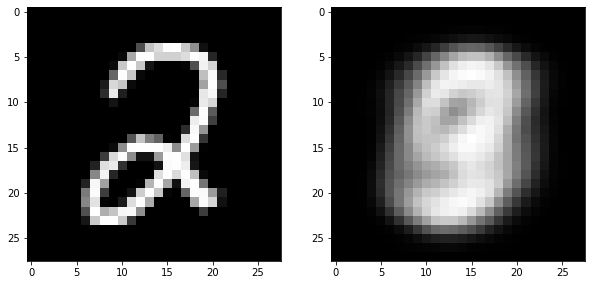

In [ ]:
test_img = X_validation[int(np.floor(np.random.rand() * X_validation.shape[0]))]
test = model.forward_propagation(test_img)[0][-1]

test_img = test_img.reshape(28, 28)
test = test.reshape(28, 28)

fig, axs = pyplot.subplots(1, 2)
fig.set_size_inches(10,5)
axs[0].imshow(np.ones_like(test_img) - test_img , cmap='Greys')
axs[1].imshow(np.ones_like(test) - test, cmap='Greys')
pyplot.show()

In [ ]:
model_64 = MLP(X_train, X_train, 0.001, layers_list=[64], momentum=0)
val_PSNR, val_MSE, train_PSNR, train_MSE = model_64.train(X_validation, X_validation, 5)
test_MSE = np.mean(model_64.MSE(X_test, X_test))

Error on test set: 0.0678


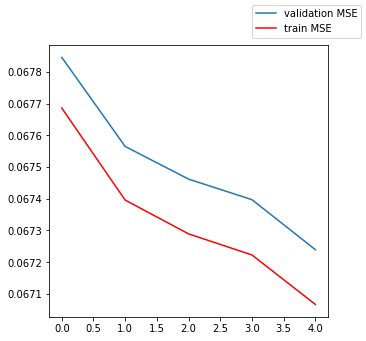

In [ ]:
fig, axs = pyplot.subplots(1, 1)
fig.set_size_inches(5,5)

axs.plot(range(len(val_MSE)), val_MSE, label = 'validation MSE')
axs.plot(range(len(train_MSE)), train_MSE, 'r', label = 'train MSE')
fig.legend()
print("Error on test set:", round(test_MSE, ndigits = 4))

pyplot.show()

In [ ]:
model_128 = MLP(X_train, X_train, 0.001, layers_list=[128], momentum=0)
val_PSNR, val_MSE, train_PSNR, train_MSE = model_128.train(X_validation, X_validation, 5)
test_MSE = np.mean(model_128.MSE(X_test, X_test))

Error on test set: 0.0501


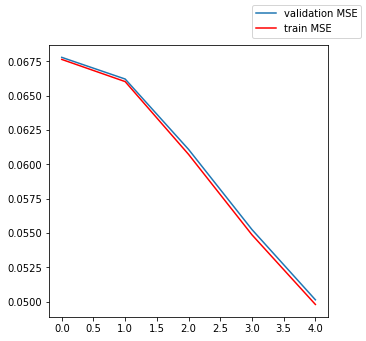

In [ ]:
fig, axs = pyplot.subplots(1, 1)
fig.set_size_inches(5,5)

axs.plot(range(len(val_MSE)), val_MSE, label = 'validation MSE')
axs.plot(range(len(train_MSE)), train_MSE, 'r', label = 'train MSE')
fig.legend()
print("Error on test set:", round(test_MSE, ndigits = 4))

pyplot.show()

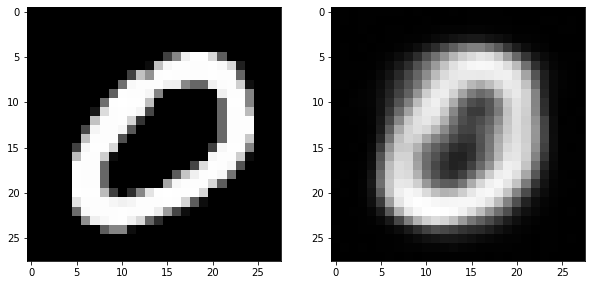

In [ ]:
test_img = X_validation[int(np.floor(np.random.rand() * X_validation.shape[0]))]
test = model_128.forward_propagation(test_img)[0][-1]

test_img = test_img.reshape(28, 28)
test = test.reshape(28, 28)

fig, axs = pyplot.subplots(1, 2)
fig.set_size_inches(10,5)
axs[0].imshow(np.ones_like(test_img) - test_img , cmap='Greys')
axs[1].imshow(np.ones_like(test) - test, cmap='Greys')
pyplot.show()

In [ ]:
model_3_layers = MLP(X_train, X_train, 0.001, layers_list=[256,64,256], momentum=0)
val_PSNR, val_MSE, train_PSNR, train_MSE = model_3_layers.train(X_validation, X_validation, 5)
test_MSE = np.mean(model_3_layers.MSE(X_test, X_test))

In [ ]:
print("Error on test set:", round(test_MSE, ndigits = 4))

Error on test set: 0.0678


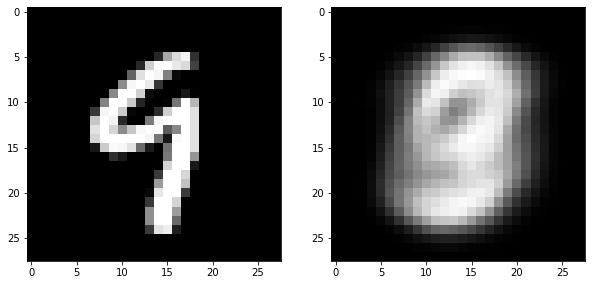

In [ ]:
test_img = X_validation[int(np.floor(np.random.rand() * X_validation.shape[0]))]
test = model_3_layers.forward_propagation(test_img)[0][-1]

test_img = test_img.reshape(28, 28)
test = test.reshape(28, 28)

fig, axs = pyplot.subplots(1, 2)
fig.set_size_inches(10,5)
axs[0].imshow(np.ones_like(test_img) - test_img , cmap='Greys')
axs[1].imshow(np.ones_like(test) - test, cmap='Greys')
pyplot.show()

In [ ]:
model_5_layers = MLP(X_train, X_train, 0.001, layers_list=[256,128,64,128,256], momentum=0)
val_PSNR, val_MSE, train_PSNR, train_MSE = model_5_layers.train(X_validation, X_validation, 5)
test_MSE = np.mean(model_5_layers.MSE(X_test, X_test))

In [ ]:
print("Error on test set:", round(test_MSE, ndigits = 4))

Error on test set: 0.0679


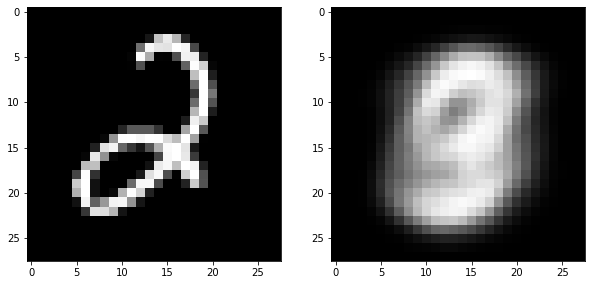

In [ ]:
test_img = X_validation[int(np.floor(np.random.rand() * X_validation.shape[0]))]
test = model_5_layers.forward_propagation(test_img)[0][-1]

test_img = test_img.reshape(28, 28)
test = test.reshape(28, 28)

fig, axs = pyplot.subplots(1, 2)
fig.set_size_inches(10,5)
axs[0].imshow(np.ones_like(test_img) - test_img , cmap='Greys')
axs[1].imshow(np.ones_like(test) - test, cmap='Greys')
pyplot.show()

In [ ]:
model_128_relu = MLP(X_train, X_train, 0.001, layers_list=[128], momentum=0, activation = 'relu')
val_PSNR, val_MSE, train_PSNR, train_MSE = model_128_relu.train(X_validation, X_validation, 5)
test_MSE = np.mean(model_128_relu.MSE(X_test, X_test))

Error on test set: 0.0077


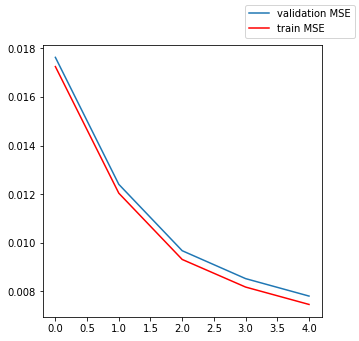

In [ ]:
fig, axs = pyplot.subplots(1, 1)
fig.set_size_inches(5,5)

axs.plot(range(len(val_MSE)), val_MSE, label = 'validation MSE')
axs.plot(range(len(train_MSE)), train_MSE, 'r', label = 'train MSE')
fig.legend()
print("Error on test set:", round(test_MSE, ndigits = 4))

pyplot.show()

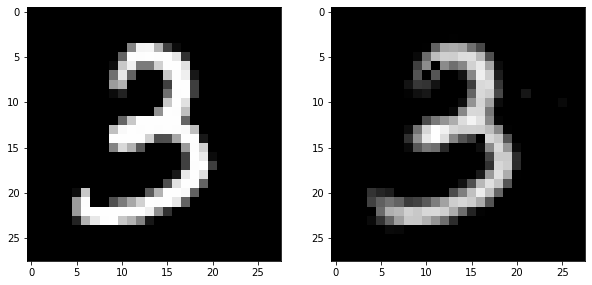

In [ ]:
test_img = X_validation[int(np.floor(np.random.rand() * X_validation.shape[0]))]
test = model_128_relu.forward_propagation(test_img)[0][-1]

test_img = test_img.reshape(28, 28)
test = test.reshape(28, 28)

fig, axs = pyplot.subplots(1, 2)
fig.set_size_inches(10,5)
axs[0].imshow(np.ones_like(test_img) - test_img , cmap='Greys')
axs[1].imshow(np.ones_like(test) - test, cmap='Greys')
pyplot.show()

In [ ]:
model1 = MLP(X_train, X_train, 1e-2, layers_list=[128], momentum=0, activation = 'relu')
model2 = MLP(X_train, X_train, 1e-6, layers_list=[128], momentum=0, activation = 'relu')
val_PSNR_1, val_MSE_1, train_PSNR_1, train_MSE_1 = model1.train(X_validation, X_validation, 5)
val_PSNR_2, val_MSE_2, train_PSNR_2, train_MSE_2 = model2.train(X_validation, X_validation, 5)
test_MSE_1 = np.mean(model1.MSE(X_test, X_test))
test_MSE_2 = np.mean(model2.MSE(X_test, X_test))

Error on test set for learning rate = 1e-2: 0.0128
Error on test set for learning rate = 1e-6: 0.1046


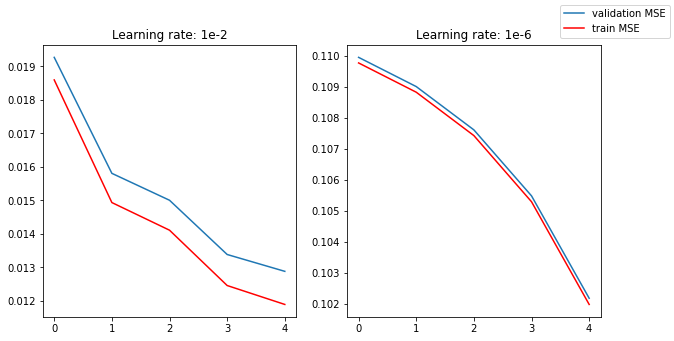

In [ ]:
fig, axs = pyplot.subplots(1, 2)
fig.set_size_inches(10,5)

axs[0].plot(range(len(val_MSE_1)), val_MSE_1, label = 'validation MSE')
axs[0].plot(range(len(train_MSE_1)), train_MSE_1, 'r', label = 'train MSE')
axs[0].set_title('Learning rate: 1e-2')
axs[1].plot(range(len(val_MSE_2)), val_MSE_2)
axs[1].plot(range(len(train_MSE_2)), train_MSE_2, 'r')
axs[1].set_title('Learning rate: 1e-6')
fig.legend()
print("Error on test set for learning rate = 1e-2:", round(test_MSE_1, ndigits = 4))
print("Error on test set for learning rate = 1e-6:", round(test_MSE_2, ndigits = 4))

pyplot.show()

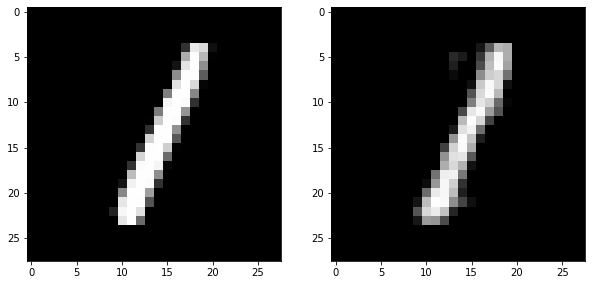

In [ ]:
test_img = X_validation[int(np.floor(np.random.rand() * X_validation.shape[0]))]
test = model1.forward_propagation(test_img)[0][-1]

test_img = test_img.reshape(28, 28)
test = test.reshape(28, 28)

fig, axs = pyplot.subplots(1, 2)
fig.set_size_inches(10,5)
axs[0].imshow(np.ones_like(test_img) - test_img , cmap='Greys')
axs[1].imshow(np.ones_like(test) - test, cmap='Greys')
pyplot.show()

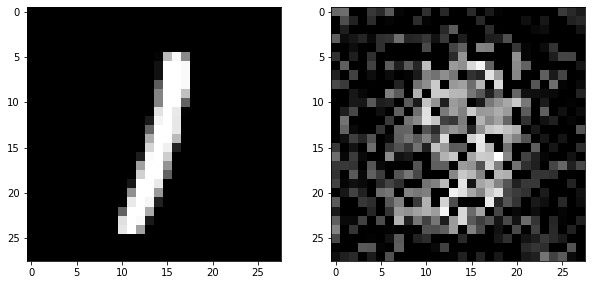

In [ ]:
test_img = X_validation[int(np.floor(np.random.rand() * X_validation.shape[0]))]
test = model2.forward_propagation(test_img)[0][-1]

test_img = test_img.reshape(28, 28)
test = test.reshape(28, 28)

fig, axs = pyplot.subplots(1, 2)
fig.set_size_inches(10,5)
axs[0].imshow(np.ones_like(test_img) - test_img , cmap='Greys')
axs[1].imshow(np.ones_like(test) - test, cmap='Greys')
pyplot.show()

In [ ]:
model1 = MLP(X_train, X_train, 1e-3, layers_list=[128], momentum=0, activation = 'relu')
model2 = MLP(X_train, X_train, 1e-3, layers_list=[128], momentum=0, activation = 'relu')

val_PSNR_1, val_MSE_1, train_PSNR_1, train_MSE_1 = model1.train(X_validation, X_validation, 5, 8)
val_PSNR_2, val_MSE_2, train_PSNR_2, train_MSE_2 = model2.train(X_validation, X_validation, 5, 16)
test_MSE_1 = np.mean(model1.MSE(X_test, X_test))
test_MSE_2 = np.mean(model2.MSE(X_test, X_test))

Error on test set with a batch size of 8: 0.0208
Error on test set with a batch size of 16: 0.0319


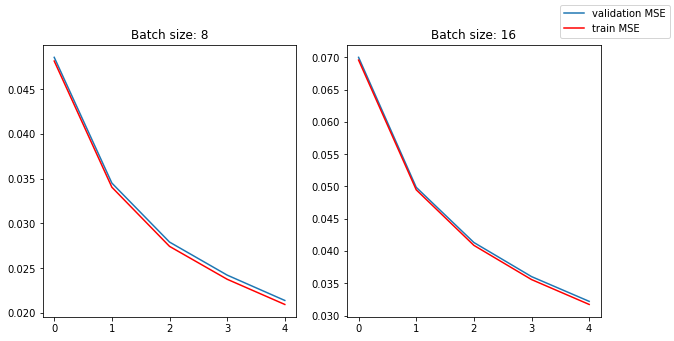

In [ ]:
fig, axs = pyplot.subplots(1, 2)
fig.set_size_inches(10,5)

axs[0].plot(range(len(val_MSE_1)), val_MSE_1, label = 'validation MSE')
axs[0].plot(range(len(train_MSE_1)), train_MSE_1, 'r', label = 'train MSE')
axs[0].set_title('Batch size: 8')
axs[1].plot(range(len(val_MSE_2)), val_MSE_2)
axs[1].plot(range(len(train_MSE_2)), train_MSE_2, 'r')
axs[1].set_title('Batch size: 16')
fig.legend()
print("Error on test set with a batch size of 8:", round(test_MSE_1, ndigits = 4))
print("Error on test set with a batch size of 16:", round(test_MSE_2, ndigits = 4))

pyplot.show()

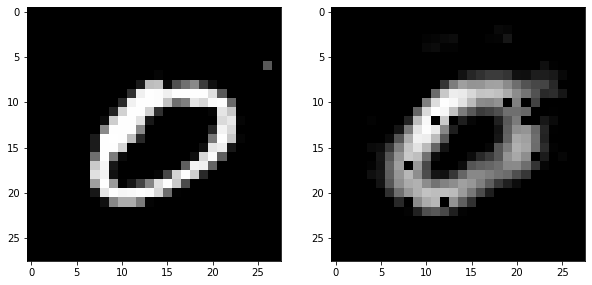

In [ ]:
test_img = X_validation[int(np.floor(np.random.rand() * X_validation.shape[0]))]
test = model1.forward_propagation(test_img)[0][-1]

test_img = test_img.reshape(28, 28)
test = test.reshape(28, 28)

fig, axs = pyplot.subplots(1, 2)
fig.set_size_inches(10,5)
axs[0].imshow(np.ones_like(test_img) - test_img , cmap='Greys')
axs[1].imshow(np.ones_like(test) - test, cmap='Greys')
pyplot.show()

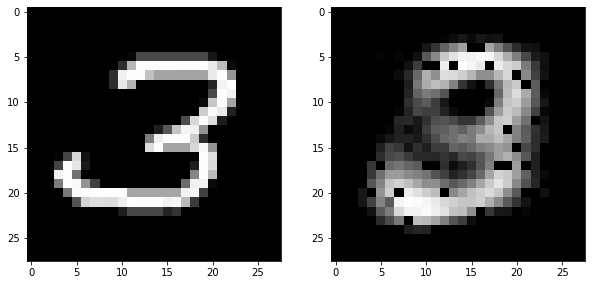

In [ ]:
test_img = X_validation[int(np.floor(np.random.rand() * X_validation.shape[0]))]
test = model2.forward_propagation(test_img)[0][-1]

test_img = test_img.reshape(28, 28)
test = test.reshape(28, 28)

fig, axs = pyplot.subplots(1, 2)
fig.set_size_inches(10,5)
axs[0].imshow(np.ones_like(test_img) - test_img , cmap='Greys')
axs[1].imshow(np.ones_like(test) - test, cmap='Greys')
pyplot.show()

In [ ]:
model = MLP(X_train, X_train, 1e-3, layers_list=[128], momentum=0, activation = 'relu')

val_PSNR, val_MSE, train_PSNR, train_MSE = model.train(X_validation, X_validation, 5)

In [ ]:
test_MSE = np.mean(model.MSE(X_test, X_test))
print("Error on test set:", round(test_MSE, ndigits = 4))

Error on test set: 0.0087


Error on test set: 0.0087


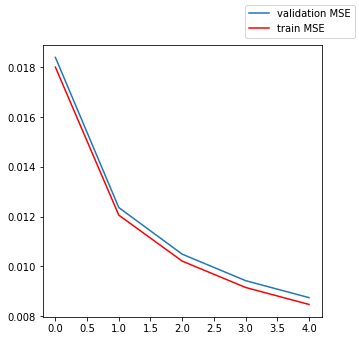

In [ ]:
fig, axs = pyplot.subplots(1, 1)
fig.set_size_inches(5,5)

axs.plot(range(len(val_MSE)), val_MSE, label = 'validation MSE')
axs.plot(range(len(train_MSE)), train_MSE, 'r', label = 'train MSE')
fig.legend()
print("Error on test set:", round(test_MSE, ndigits = 4))

pyplot.show()

In [ ]:
X_train_encoded = np.squeeze(np.array([model.forward_propagation(x)[0][1] for x in X_train]), axis = 2)
X_train_encoded.shape

(10200, 128)

In [ ]:
X_test_encoded = np.squeeze(np.array([model.forward_propagation(x)[0][1] for x in X_test]), axis = 2)
X_test_encoded.shape

(2000, 128)

In [ ]:
X_validation_encoded = np.squeeze(np.array([model.forward_propagation(x)[0][1] for x in X_validation]), axis = 2)
X_validation_encoded.shape

(1800, 128)

In [ ]:
y_train_temp = np.zeros((y_train.shape[0], 10))
for i in range(y_train.shape[0]):
    y_train_temp[i][y_train[i]] = 1
y_train = np.copy(y_train_temp)
print(y_train.shape)

y_test_temp = np.zeros((y_test.shape[0], 10))
for i in range(y_test.shape[0]):
    y_test_temp[i][y_test[i]] = 1
y_test = np.copy(y_test_temp)
print(y_test.shape)

y_validation_temp = np.zeros((y_validation.shape[0], 10))
for i in range(y_validation.shape[0]):
    y_validation_temp[i][y_validation[i]] = 1
y_validation = np.copy(y_validation_temp)
print(y_validation.shape)

(10200, 10)
(2000, 10)
(1800, 10)


In [ ]:
classifier_64 = MLP(X_train_encoded, y_train, 1e-3, layers_list=[64], momentum=0, activation = 'relu')
val_PSNR, val_MSE, train_PSNR, train_MSE = classifier_64.train(X_validation_encoded, y_validation, 60)
test_MSE = np.mean(classifier_64.MSE(X_test_encoded, y_test))
print("Error on test set:", round(test_MSE, ndigits = 4))

Error on test set: 0.011


In [ ]:
classifier_32 = MLP(X_train_encoded, y_train, 1e-3, layers_list=[32], momentum=0, activation = 'relu')
val_PSNR, val_MSE, train_PSNR, train_MSE = classifier_32.train(X_validation_encoded, y_validation, 60)
test_MSE = np.mean(classifier_32.MSE(X_test_encoded, y_test))
print("Error on test set:", round(test_MSE, ndigits = 4))

Error on test set: 0.0218
